# Building a Model with FIFA 20 Players and Attributes

## Overview
This notebook will clean, format, and develop new features to input into a multiple linear regression model to predict an individual football player's `potential` rating in the FIFA 2020 game. Players in FIFA 2020 are given statistics on their skill set, favored positions, club/nationality information, player traits, and characteristics. Finally, a player receives an `overall` rating that gamers use to identify the quality of the player/team they are using. In the game, certain individual players have more `potential` than others. It allows gamers to purchase players in the career mode setting. This encourages them to find players with the most `potential` to develop and grow them into top players and possibly sell them for the most money. `potential` generally has the most significant gain for younger players in the top teams. Still, other factors come into play that influences their rating. 

The model developed in this process will be used to output a final `potential` rating for players in the game and can be used by EA sports to price players at different tiers. The pricing tiers is how EA sports convert unpaid gamers into paid gamers. For example, if a gamer sees a FIFA 2020 player with a promising potential rating, they will be encouraged to spend real money to acquire them. The gameplay process allows in-game purchases, and seeing players with the most potential has the most significant upside.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import random as rand
import sklearn
import statsmodels.formula.api as smf

sns.set_style("darkgrid", {"axes.facecolor": ".9"})


# Setting print options
pd.set_option('display.max_rows',     500)
pd.set_option('display.max_columns',  500)
pd.set_option('display.width',       1000)
pd.set_option('display.max_colwidth', 100)

In [2]:
df = pd.read_csv('players/players_20.csv')

## Cleaning
Cleaning some preliminary columns from the start. Throughout the model we will be removing unnecessary columns as we develop new features.

In [3]:
df.drop(['player_url','long_name', 'sofifa_id'], axis = 1, inplace = True)

# Feature Engineering

Our goal is to develop the best model to help predict a football payer's `potential` in the game. This will encourage gamers to buy in-app tokens to acquire high potential players. To achieve this, we need to engineer additional features to help enhance the model's performance. We are given a set amount of data inputs and a more robust model, and we need to develop intuition and strategies for new features. The next few steps will encompass formatting and developing additional features that can be used in the model.

## Time/Dates


### Converting data types

In [4]:
# Convert contract end year to date trunc
df['contract_valid_until'] = pd.to_datetime(df['contract_valid_until'], format='%Y')

# Convert dob to date format
df[["dob", "joined", "contract_valid_until"]] = df[["dob", "joined", "contract_valid_until"]].apply(pd.to_datetime)

### Adding new date based columns

Columns added:
1. Counting the number of years between current date and expected contract expiration date
2. Number of days since the player joined their club from current date
3. Extracting columns:
    1. Month
    2. Day
    3. Year

In [5]:
# contract expriation years
df['contract_valid_years'] = ((pd.to_datetime(df['contract_valid_until']).dt.date - pd.datetime.now().date())
                            / pd.Timedelta(1, unit='y')).fillna(0).astype('int64')

/Users/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# converting to see how many days from now till contract expires
df['days_since_joined'] = ((pd.datetime.now().date() - pd.to_datetime(df['joined']).dt.date)
                            / pd.Timedelta(1, unit='d')).fillna(0).astype('int64')

In [7]:
# month player was born
df['birth_month'] = df["dob"].dt.month

# day player was born
df['birth_day'] = df["dob"].dt.day

# day player was born
df['birth_year'] = df["dob"].dt.year

## Positions

1. Cleaning team position and replace similar values to ensure they match.
    - RES (reserve) and SUB (substitute) are the same position
    - CF (centre forward) and ST (striker) are the same position
2. Creating a new position 'main_position', which ignore if a player is listed as a SUB/RES. This will allow us to capture their preferred playing position.

In [9]:
# converting RES to SUB since they mean the same
df['team_position'].replace('RES', 'SUB', inplace = True)
df['team_position'].replace('CF', 'ST', inplace = True)

# adding a new column 'Main Position'
# columns to clean
cleaning_positions = df.loc[:,['sofifa_id','player_positions', 'team_position']]

# formatting the lpayer position to get single position
cleaning_positions['cleaned'] = cleaning_positions['player_positions']\
                                .apply(lambda row: pd.Series(str(row).split(",")[0]))

# Convert RES or SUB rows to the new cleaned position
for index, row in cleaning_positions.iterrows():
    if row['team_position'] in ['RES', 'SUB']:
        cleaning_positions.loc[index, "team_position"] = row['cleaned']
        
        
# saving the cleaned variables into original dataframe
df['main_position'] = cleaning_positions['team_position']


# dropping players without a position
df['team_position'].dropna(inplace = True)
df['main_position'].dropna(inplace = True)

/Users/jason/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [10]:
# # create a boolean and new column for each position
# def position_boolean(position, new_column, input_colum):
#     for index, row in df.iterrows():
#         if row[input_colum] ==  position:
#             df.loc[index, new_column] = 1
#         else:
#             df.loc[index, new_column] = 0

### Team Position

Creating dummy variables for each `team_position` and saving it with the preffix `team_`

In [12]:
# get dummies
team_position = pd.get_dummies(df.loc[:, 'team_position'])

# saving list to pass into dataframe
team_position_cols = list(team_position.columns)

cols_formatted = []
for col in team_position_cols:
    cols_formatted.append("team_{}".format(col))

# joining codings together
df[cols_formatted] = team_position

### Main Position

Creating dummy variables for each `main_position` and saving it with the preffix `main_`

In [14]:
# get dummies
main_position = pd.get_dummies(df.loc[:, 'main_position'])

# saving list to pass into dataframe
main_position_cols = list(main_position.columns)

cols_formatted = []
for col in main_position_cols:
    cols_formatted.append("main_{}".format(col))
    
# joining codings together
df[cols_formatted] = main_position

## Remaning Categorical Values

Creating dummy variables for the remaining categorical variables.

In [15]:
# list categorical values
categories = ['preferred_foot', 'work_rate', 'international_reputation', 
              'skill_moves', 'body_type']
 
# convert columns to categories
for col in df.columns:
    if col in categories:
        df[col] = df[col].astype('category')
        
# get dummies
dummies = pd.get_dummies(df.loc[:, categories])

# saving list to pass into dataframe
dummies_cols = list(dummies.columns)

# joining codings together
df[dummies_cols] = dummies

## Traits & Characteristics

There are several columns with more than 1 data point in a single cell. For example, the trait column can have multiple traits embedded in one player. To ensure we are capturing each trait I will split them up and also count the total number of embedded traits.

### Count
First, we will count and create a new column for each multiple stored value.

In [16]:
# adding counts for the number of values per column
df['position_count'] = df['player_positions'].str.split(',').str.len()
df['trait_count'] = df['player_traits'].str.split(',').str.len().fillna(0).astype('int64')
df['tag_count'] = df['player_tags'].str.split(',').str.len().fillna(0).astype('int64') 

### Trait Dummies
Next, we will create a loop that cleans, formats and outputs a boolean results for each column in the trait selection.

In [17]:
# function for traits
def player_traits(trait, column_name):
    for index, row in df.iterrows():
        if trait in row['player_traits_list']:
            df.loc[index, column_name] = 1
        else:
            df.loc[index, column_name] = 0

In [19]:
# creating new column which stores a list of the split traits
df['player_traits_list'] = df['player_traits'].str.split(',').fillna('')

# cleaning for trailing spaces in the traits list
for index, row in enumerate(df['player_traits_list']):
    word_list = []
    for word in df['player_traits_list'].iloc[index]:
        word_list.append(word.strip())
        df['player_traits_list'].iloc[index] = word_list
        
    
####### UNIQUE VALUES #########
# stripping and saving unique values
traits = []

for index, row in enumerate(df['player_traits_list']):
    for word in row:
        if word not in traits:
            traits.append(word)

# unique values from the tags list
traits = list(set(traits))


########## COLUMN NAME #########
# creating column names
traits_columns = []

for trait in traits:
    traits_columns.append(trait.replace(" ", "_").lower())

# functions to brute force creating dummy variables
for trait, column_name in zip(traits, traits_columns):
    player_traits(trait, column_name)

/Users/jason/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Tags

Next, we will create a loop that cleans, formats and outputs a boolean results for each column in the tag selection.

In [20]:
# function for tag
def player_tags(tag, column_name):
    for index, row in df.iterrows():
        if tag in row['player_tags_list']:
            df.loc[index, column_name] = 1
        else:
            df.loc[index, column_name] = 0

In [21]:
# spliting and cleaning tags
df['player_tags_list'] = df['player_tags'].str.split(',').fillna('')


####### FORMATING LISTS IN ROW ########
# cleaning for trailing spaces in the traits list
for index, row in enumerate(df['player_tags_list']):
    word_list = []
    for word in df['player_tags_list'].iloc[index]:
        word_list.append(word.replace("#","").strip())
        df['player_tags_list'].iloc[index] = word_list
        

####### UNIQUE VALUES #########
# stripping and saving unique values
tags = []

for index, row in enumerate(df['player_tags_list']):
    for word in row:
        if word not in tags:
            tags.append(word.replace("#","").strip())

# unique values from the tags list
tags = list(set(tags))


########## COLUMN NAME #########
# creating column names
tags_columns = []

for tag in tags:
    tags_columns.append(tag.replace(" ", "_").lower())

# functions to brute force creating dummy variables
for tag, column_name in zip(tags, tags_columns):
    player_tags(tag, column_name)   

# Model
Now we have developed all the necessary features, we can proceed with building the model. The first step of the process will be to use the `statsmodel` package to eliminate irrelevant/ insignificant features.

This is to identify the variables with the highest p-values so we can manually remove them and help optimize the model. If we don't do this step and look to build models using scikit learn, redundant variables will be kept and slow the model down.

## Statsmodel

In [112]:
# list of columns that can be dropped
cols_drop = ['dob', 'short_name', 'nationality', 'club', 'player_positions', 'preferred_foot', 'international_reputation',
             'skill_moves', 'weak_foot', 'work_rate', 'body_type', 'real_face', 'player_tags', 'team_position', 'loaned_from',
             'joined', 'contract_valid_until', 'main_position', 'nation_position', 'nation_jersey_number', 'gk_diving', 'gk_handling', 
             'gk_reflexes', 'gk_speed', 'gk_kicking', 'gk_positioning', 'player_traits', 'goalkeeping_diving', 'goalkeeping_handling',
             'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs', 'lw', 'lf' ,
             'cf' , 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb',                                  
             'lb', 'lcb', 'cb', 'rcb', 'rb', 'player_traits_list', 'player_tags_list']

# creating temp dataframe for model testing
model_df = df.drop(cols_drop, axis = 1)
model_df.dropna(inplace = True)

### Train/Test Split
Below we create the train/test split data sets. We want to ensure we are training the model on a portion of our data and then saving the remaining sample for test/validation. A reminder the target (`Y`) variable we are predicting is `potential`.

In [479]:
# imports
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [480]:
# drop remaining target variable
player_data = model_df.drop(['potential'], 
                         axis = 1)

# drop remaining categorical variables - creating the y variable
player_target = model_df["potential"]

# preparing training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    player_data,
                                                    player_target,
                                                    test_size = 0.25,
                                                    random_state = 18)

In [485]:
# # make explantory variable set
# for col in player_data:
#     print(f"player_train['{col}'] +")

### Results

We start with 173 columns. After running the model through statsmodel we go through the process of elimination on variables for variables over 0.05, which is the level of significance set. At the end of the process we end up removing 64 redundant columns and keep the remaining 109 columns. The results recorded a relatively high R-square of 0.854. Now with the optimized model after removing the high p-values we can proceed to feed in the same inputs into the scikit learn OLS package and obtain prediction results.

In [472]:
# linear model
player_train = pd.concat([X_train,y_train], axis = 1)

linear_model = smf.ols(formula = """potential ~ 
                                    player_train['age'] +
                                    player_train['height_cm'] +
                                    player_train['overall'] +
                                    player_train['value_eur'] +
                                    player_train['release_clause_eur'] +
                                    player_train['team_jersey_number'] +
                                    player_train['physic'] +
                                    player_train['attacking_heading_accuracy'] +
                                    player_train['movement_sprint_speed'] +
                                    player_train['power_shot_power'] +
                                    player_train['power_jumping'] +
                                    player_train['power_strength'] +
                                    player_train['mentality_aggression'] +
                                    player_train['mentality_vision'] +
                                    player_train['mentality_penalties'] +
                                    player_train['mentality_composure'] +
                                    player_train['defending_sliding_tackle'] +
                                    player_train['contract_valid_years'] +
                                    player_train['days_since_joined'] +
                                    player_train['birth_month'] +
                                    player_train['birth_year'] +
                                    player_train['team_CAM'] +
                                    player_train['team_CB'] +
                                    player_train['team_CDM'] +
                                    player_train['team_CM'] +
                                    player_train['team_GK'] +
                                    player_train['team_LAM'] +
                                    player_train['team_LB'] +
                                    player_train['team_LCB'] +
                                    player_train['team_LCM'] +
                                    player_train['team_LDM'] +
                                    player_train['team_LF'] +
                                    player_train['team_LM'] +
                                    player_train['team_LS'] +
                                    player_train['team_LW'] +
                                    player_train['team_LWB'] +
                                    player_train['team_RAM'] +
                                    player_train['team_RB'] +
                                    player_train['team_RCB'] +
                                    player_train['team_RCM'] +
                                    player_train['team_RDM'] +
                                    player_train['team_RF'] +
                                    player_train['team_RM'] +
                                    player_train['team_RS'] +
                                    player_train['team_RW'] +
                                    player_train['team_RWB'] +
                                    player_train['team_ST'] +
                                    player_train['team_SUB'] +
                                    player_train['main_CAM'] +
                                    player_train['main_CB'] +
                                    player_train['main_CDM'] +
                                    player_train['main_CF'] +
                                    player_train['main_CM'] +
                                    player_train['main_GK'] +
                                    player_train['main_LAM'] +
                                    player_train['main_LB'] +
                                    player_train['main_LCB'] +
                                    player_train['main_LCM'] +
                                    player_train['main_LDM'] +
                                    player_train['main_LF'] +
                                    player_train['main_LM'] +
                                    player_train['main_LS'] +
                                    player_train['main_LW'] +
                                    player_train['main_LWB'] +
                                    player_train['main_RAM'] +
                                    player_train['main_RB'] +
                                    player_train['main_RCB'] +
                                    player_train['main_RCM'] +
                                    player_train['main_RDM'] +
                                    player_train['main_RF'] +
                                    player_train['main_RM'] +
                                    player_train['main_RS'] +
                                    player_train['main_RW'] +
                                    player_train['main_RWB'] +
                                    player_train['main_ST'] +
                                    player_train['preferred_foot_Left'] +
                                    player_train['preferred_foot_Right'] +
                                    player_train['work_rate_High/High'] +
                                    player_train['work_rate_High/Low'] +
                                    player_train['work_rate_High/Medium'] +
                                    player_train['work_rate_Low/High'] +
                                    player_train['work_rate_Low/Low'] +
                                    player_train['work_rate_Low/Medium'] +
                                    player_train['work_rate_Medium/High'] +
                                    player_train['work_rate_Medium/Low'] +
                                    player_train['work_rate_Medium/Medium'] +
                                    player_train['international_reputation_1'] +
                                    player_train['international_reputation_2'] +
                                    player_train['international_reputation_3'] +
                                    player_train['international_reputation_4'] +
                                    player_train['international_reputation_5'] +
                                    player_train['skill_moves_2'] +
                                    player_train['skill_moves_3'] +
                                    player_train['skill_moves_4'] +
                                    player_train['skill_moves_5'] +
                                    player_train['body_type_Lean'] +
                                    player_train['body_type_Normal'] +
                                    player_train['body_type_Stocky'] +
                                    player_train['position_count'] +
                                    player_train['trait_count'] +
                                    player_train['skilled_dribbling'] +
                                    player_train['selfish'] +
                                    player_train['long_passer_(cpu_ai_only)'] +
                                    player_train['power_free-kick'] +
                                    player_train['avoids_using_weaker_foot'] +
                                    player_train['injury_free'] +
                                    player_train['giant_throw-in'] +
                                    player_train['tactician'] +
                                    player_train['poacher']
""",
                                    data = player_train)

train_result = linear_model.fit()
train_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              potential   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     744.3
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:12:25   Log-Likelihood:                -25653.
No. Observations:               11307   AIC:                         5.148e+04
Df Residuals:                   11218   BIC:                         5.214e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   -614.9263     74.909     -8.209      0.000    -761.761    -468.092
player_train['age']                           -0.2448      0.092     -2.673      0.008      -0.424      -0.065
player_train['height_cm']                     -0.0150      0.006     -2.715      0.007      -0.026      -0.004
player_train['overall']                        0.8538      0.009     97.629      0.000       0.837       0.871
player_train['value_eur']                  -3.609e-07   3.73e-08     -9.668      0.000   -4.34e-07   -2.88e-07
player_train['release_clause_eur']          1.636e-07   1.88e-08      8.720      0.000    1.27e-07       2e-07
player_train['team_jersey_number']             0.0095      0.001      6.639      0.000       0.007       0.012
player_train['physic']                        -0.1661      0.011    -15.320      0.000      -0.187      -0.145
player_train['attacking_heading_accuracy']     0.0099      0.003      2.918      0.004       0.003       0.017
player_train['movement_sprint_speed']         -0.0159      0.003     -5.685      0.000      -0.021      -0.010
player_train['power_shot_power']              -0.0079      0.003     -2.779      0.005      -0.013      -0.002
player_train['power_jumping']                  0.0087      0.002      3.606      0.000       0.004       0.013
player_train['power_strength']                 0.0624      0.007      9.191      0.000       0.049       0.076
player_train['mentality_aggression']           0.0357      0.003     10.274      0.000       0.029       0.042
player_train['mentality_vision']               0.0089      0.003      2.549      0.011       0.002       0.016
player_train['mentality_penalties']            0.0172      0.003      5.902      0.000       0.011       0.023
player_train['mentality_composure']            0.0231      0.004      5.557      0.000       0.015       0.031
player_train['defending_sliding_tackle']       0.0109      0.003      3.949      0.000       0.006       0.016
player_train['contract_valid_years']           0.0964      0.025      3.917      0.000       0.048       0.145
player_train['days_since_joined']           8.746e-05   3.19e-05      2.743      0.006     2.5e-05       0.000
player_train['birth_month']                    0.0583      0.013      4.454      0.000       0.033       0.084
player_train['birth_year']                     0.7761      0.092      8.466      0.000       0.596       0.956
player_train['team_CAM']                     -23.5422      2.888     -8.152      0.000     -29.203     -17.881
player_train['team_CB']                      -23.7308      2.893     -8.202      0.000     -29.402     -18.059
player_train['team_CDM']                     -23.6091      2.890     -8.169      0.000

## Scikit Learn

Using Scikit learn's `linear_model` to run a linear regression we can pass in **only** the features we kept from the statsmodel results. We see that a lot of the features around a players position proved to be statistically significant which is promising since we developed it in the feature engineering stage.

In [232]:
#import scikit learn linear
import sklearn.linear_model
from sklearn.model_selection import train_test_split

In [483]:
# defining x_variables that we kept from the Stats model

x_variables = [ 
                'age',
                'height_cm',
                'overall',
                'value_eur',
                'release_clause_eur',
                'team_jersey_number',
                'physic',
                'attacking_heading_accuracy',
                'movement_sprint_speed',
                'power_shot_power',
                'power_jumping',
                'power_strength',
                'mentality_aggression',
                'mentality_vision',
                'mentality_penalties',
                'mentality_composure',
                'defending_sliding_tackle',
                'contract_valid_years',
                'days_since_joined',
                'birth_month',
                'birth_year',
                'team_CAM',
                'team_CB',
                'team_CDM',
                'team_CM',
                'team_GK',
                'team_LAM',
                'team_LB',
                'team_LCB',
                'team_LCM',
                'team_LDM',
                'team_LF',
                'team_LM',
                'team_LS',
                'team_LW',
                'team_LWB',
                'team_RAM',
                'team_RB',
                'team_RCB',
                'team_RCM',
                'team_RDM',
                'team_RF',
                'team_RM',
                'team_RS',
                'team_RW',
                'team_RWB',
                'team_ST',
                'team_SUB',
                'main_CAM',
                'main_CB',
                'main_CDM',
                'main_CF',
                'main_CM',
                'main_GK',
                'main_LAM',
                'main_LB',
                'main_LCB',
                'main_LCM',
                'main_LDM',
                'main_LF',
                'main_LM',
                'main_LS',
                'main_LW',
                'main_LWB',
                'main_RAM',
                'main_RB',
                'main_RCB',
                'main_RCM',
                'main_RDM',
                'main_RF',
                'main_RM',
                'main_RS',
                'main_RW',
                'main_RWB',
                'main_ST',
                'preferred_foot_Left',
                'preferred_foot_Right',
                'work_rate_High/High',
                'work_rate_High/Low',
                'work_rate_High/Medium',
                'work_rate_Low/High',
                'work_rate_Low/Low',
                'work_rate_Low/Medium',
                'work_rate_Medium/High',
                'work_rate_Medium/Low',
                'work_rate_Medium/Medium',
                'international_reputation_1',
                'international_reputation_2',
                'international_reputation_3',
                'international_reputation_4',
                'international_reputation_5',
                'skill_moves_2',
                'skill_moves_3',
                'skill_moves_4',
                'skill_moves_5',
                'body_type_Lean',
                'body_type_Normal',
                'body_type_Stocky',
                'position_count',
                'trait_count',
                'skilled_dribbling',
                'selfish',
                'long_passer_(cpu_ai_only)',
                'power_free-kick',
                'avoids_using_weaker_foot',
                'injury_free',
                'giant_throw-in',
                'tactician',
                'poacher'
]

In [484]:
len(x_variables)

109

In [415]:
# drop remaining target variable
player_data = model_df.loc[:,x_variables]

# drop remaining categorical variables - creating the y variable
player_target = model_df["potential"]

# preparing training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                                    player_data,
                                                    player_target,
                                                    test_size = 0.25,
                                                    random_state = 18)

### OLS
Ordinary Least Squares regression is one of the more common practices for modeling. It studies the relationship from the X variables and how it affects the values y - in our case, `potential`. This model is a good starting point to see how it performs and see if there is anywhere that needs to be pivoted to obtain a higher-performing model based on the features.

OLS is not the only optimization strategy. It is the most popular for this kind of task since the regression outputs (that are, coefficients) are unbiased estimators of the real values.

In [486]:
# Create the regressor: reg_all
reg_all = sklearn.linear_model.LinearRegression()

# Fit the regressor to the training data
model = reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# check scores
print('Regression Training Score:', reg_all.score(X_train, y_train).round(4))
print('Regression Testing Score:', reg_all.score(X_test, y_test).round(4))

regression_train = reg_all.score(X_train, y_train).round(4)
regression_test = reg_all.score(X_test, y_test).round(4)

Regression Training Score: 0.8544
Regression Testing Score: 0.8488


As expected we see similar results to our `statsmodel` model. The regression delta between the training and testing group is also reasonably close.

### Visualizing Results
We obtained the `y_pred` variable, essentially the linear regression equation, combining all the coefficients we saw from the statsmodel stage into a simplified function to calculate the test model results automatically.

Below we can visualize what the delta between prediction and look like. This will give a sense of how well/poor the model's prediction performed relative to the R-squared value of 0.8538.

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 <a list of 9 Text yticklabel objects>)

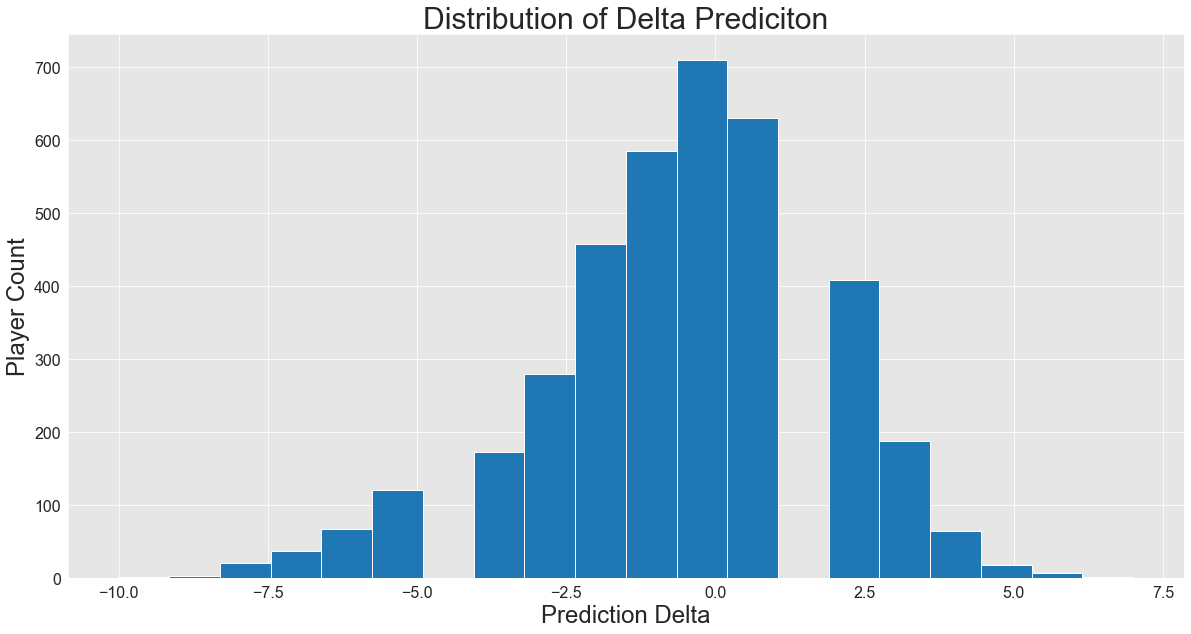

In [495]:
# create a dataframe with all the y_pred results
test  = X_test.reset_index()

test['results'] = pd.DataFrame(list(y_pred.astype('int64')))

# store relevant columns only
test = test[['index','results']]

# create a copy of model_df
original_df = model_df.reset_index()

# join and keep only values with results (so the test data)
results = original_df.merge(test, how = 'inner', on = 'index')[['potential', 'results']]

# new column to check the difference in results
results['diff'] = results['results'] - results['potential']

plt.figure(figsize = (20,10))
results['diff'].hist(bins = 20)
plt.title('Distribution of Delta Prediciton', fontsize = 30)
plt.xlabel('Prediction Delta', fontsize = 24)
plt.ylabel('Player Count', fontsize = 24)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

From this histogram, we can see that 50% of the model's prediction fell within -1 to 1 from the actual `potential` value. While this is certainly not perfect, it gives a good sense that there are not that many players with astronomically incorrect predictions. The histogram shows that the model's worse prediction was a -9 delta from the original `potential` rating for only 1 player.

This model can continue to be optimized and improved with additional features.